# Rewrite of POLE, written by Conrad
(See e.g. "Including Systematic Uncertainties in Confidence Interval Construction for Poisson Statistics")
- Cole Kampa
- 11-30-2020

# Fortran Code (raw)

In [ ]:
c ---------------------------------------------------------------
c pole.f
c
c performs Confidence belt construction for a Poissonian
c Process including systematic uncertainties.
c 
c 
c
c                                    Jan Conrad, November 2003
c                 
c
c-------------------------------------------------------------

      character*50 filehb
      character*70 filein,fileout

      common /hbfile/ filehb

      parameter       (nbookw = 5000000)
      common /pawc/    hspace(nbookw)
   
      integer normtrue,used,FCtrue,steps,ctrue
      real*4 effa,sac,sbg,fluxfactor,bsac
      real*4 trisigflu,fmax,help,width,conflevel
      real*4 fluxarray(1000),matrix(1000,100)
      real*4 x(10000),y(10000),z(10000),fi(10000)
      real*4 background,zenith,filow,Philow,Phihigh
      integer dist(100),noent,nent(1000),nh
      integer filltrue,spar,bar,bkpar,ncalc
      integer filetrue,nobs,outunit2

c Calls Routine that reads from inifile cobe.ini     

      call readin(sac,sbg,fluxfactor,fmax
     >,filehb,normtrue,background,nobs,FCtrue
     >,bsac,width,filltrue,ctrue,spar,bar,bkpar
     >,filetrue,filein,fileout,conflevel)
      




c Tell User which parameters: 

       print *, 'Performing Conf Belt Const :'
       print *, 'Output hbfile:     ', filehb  
       print *, 'fill diagnostic histos',filltrue
       print 100, 'Confidence Level',conflevel
       print 200, 'Condition (1=yes)', normtrue 
       print 100, 'stepwidth : ', width
       print 200, 'Feldman Cousins    ', FCtrue
       print 100, 'fluxfactor:        ', fluxfactor
       print *, 'Read from file: ',filein
       print *, ' Write to file: ',fileout
       print 100, 'Exp. BG events     ', background
       print 200, 'Measured events    ', nobs
       print *, ' '
       print *, 'Used Paramterisation :'
       print *, 'Gaussian = 1'
       print *, 'flat = 2'
       print *, 'log-normal = 3'
       print *,' '
       print 100, 'rel Aeff unc (sig):', sac
       print *,'Parametrization:',spar
       print 100, 'rel Aeff unc (bck):', bsac
       print *,'Parametrization:', bar
       print 100, 'rel bg unc:        ', sbg
       print *, 'Parametrization:',bkpar
       print 100, 'max flux:          ', fmax
   
       outunit2 = 9

       help = fmax/width
       steps = int(help)

       print *,'Number of steps: ',steps
       print *,'CAUTION: not bigger than 1000!'
       
c Book Histogramms

      call hlimit(nbookw)

      call hbook2(50,'Ntot vs. flux (FC)',500,0.,50.,steps,0.0,fmax,1.)
      call hbook2(40,'Ntot vs. flux (Ney)',500,0.,50.,steps,0.0,fmax,1.)
      call hbook1(100,'N dist',100,0.,100.,0.)


c Diagnostics

      if (filltrue.eq.1) then
       call hbook2(31,'P_best Dist',steps,0.,20000.,1000,0.0,fmax,1.)
      endif




c Read input from file 

      open (outunit2, file=fileout, status = 'new')

      if (filetrue.eq.1) then 
         call read_grid(filein,x,y,ncalc)
      print *,"-"
      print *,"-"
      print *,"Mode: Read input from file "
      print *,"-"
      else
c or not !     
        ncalc = 1.
      print *,"-"  
      print *,"-"
      print *," Mode: single construction"
      print *,"-"
      endif



      do p = 1,ncalc            ! Loop over input nobs/BG pairs.

         Philow = 0.
         Phihigh = 0.

         call hreset(50,' ')
         call hreset(40,' ')
         call hreset(100,' ')

         if (filetrue.eq.1) then  
            nobs = y(p)
            background = x(p)
         endif   

         print *, "-" 
         print *, "Performing Construction for nO/bg: ", nobs, 
     >        background
         print *, "-"
         print *, "-" 
         print *, "RanLux Messages"
         print *, "-" 
         print *," "
         trisigflux= 0.0


c     Scan through flux space and perform Construction

         used = 0
         
         call rnpset(20.)
      
         
         do i = 1,steps
            
            if (mod(i, int(steps/20)).eq.0) print *,'.'
       
            trisigflux =trisigflux+width
            fluxarray(i) = trisigflux
            
c     Diagnostics histogramms
            

            
            if (filltrue.eq.1) then
               nh = 100 + i
               call hbook1(nh,'N Dist',100,0.,100.,0.)
            endif

            call fluxlim(trisigflux,sac,sbg,i,normtrue,used,fluxfactor,
     > background,nobs,dist,FCtrue,bsac,noent,steps,width,filltrue,
     > ctrue,spar,bar,bkpar,conflevel)
            
            
c    fill matrix for Feldman Cousins
            
            do l =1,100
               matrix(i,l) = dist(l)
            enddo

            nent(i) = noent

c Diagnostics histogramms
            
            if (filltrue.eq.1) then
               nh = 1100 + i
               call hbook2(nh,'Rank Dist.',100,0.,50.,10,0.,1.,1.)
            endif
    
            fluxarray(i) = trisigflux
            trisigflux =trisigflux+width
         enddo

c Perform Likelihood Ratio construction 

         if (FCtrue.eq.1) 
     >        call FC(matrix,fluxarray,nobs,nent,steps,filltrue,
     >        Philow,Phihigh,conflevel)
         

c Write output to file !
         
         write (outunit2,400) nobs,background,
     >     Philow,Phihigh


      enddo                     ! End of nobs/bg loop
      

      
      
      close(outunit2)

 100  FORMAT(' ',A,F5.2)    
 400  FORMAT(' ',I5,' ',F5.2,' ',F5.2,' ',F5.2)
 200  FORMAT(' ',A,I5)

 9990 continue

c Open output hbook file and write histos
      call hropen(69,'out',filehb,'n',1024,ier)
      if (ier.ne.0) then 
       write (6,*) 'Error ',ier,' opening hb file'
       stop
      endif
      call hcdir('//out',' ')
      call hrout(0,icycle,' ')
      call hrend('out')
      close(69)
    
      end


ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
      subroutine fluxlim(trisigflu,sac,sbg,k,normtrue,used,fluxfactor, 
     >background,nobs,dist,FCtrue,bsac,noent,steps,width,filltrue,
     >ctrue,spar,bar,bkpar,conflevel)
c
c     This routine performs a Neyman Construction for P(flux;nobs) 
c     including systematic uncertainties
c
c     Author: Jan Conrad, February 2001       
c      
ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc


      

      real*4 efficiency,fluxfactor
      real*4 effa,conflevel
      real*4 sac,nlim,fntot(100000)
      real*4 sigfactor(3),bkfactor(3),befactor(3)
      real*4 trisigflu,bckflux,musignal,mubck,background
      real*4 a,b,sbg,bckfluxnom,resflux,bsac,width 
      integer n_tot,nbck,nsig,normtrue,steps,nobs
      integer k,used,FCtrue,dist(100),noent,nc,filltrue
      integer bar,spar,bkpar,ctrue      

c      Use this if you want to put in flux from theoretical calc
c      parameter (bckfluxnom = 123)

   
      character*50 filehb

      common /hbfile/ filehb

      parameter       (nbookw = 5000000)
      common /pawc/    hspace(nbookw)




       call hreset(100,' ')
      
      
c      Take flux from our MC
       bckfluxnom = background/fluxfactor

c Perform Pseudo Experiments to calculate Integrals
      
      j = 0
      nc = 0

      do i=1,100000



         call fluxfactors(sac,bsac,sbg,sigfactor,befactor,
     > bkfactor, ctrue)
      
         
c     uncertainty in background flux 
       
         bckflux = bckfluxnom*bkfactor(bkpar)


c Diagnostics histograms
          
         if (filltrue.eq.1) call hfill(k+2000,bkfactor(bkpar),1.,1.)

         
         
c     include flux uncertainty
         
         musignal = trisigflu*fluxfactor*sigfactor(spar)
         mubck  = bckflux*befactor(bar)
         

c     Truncation for Gaussian uncertainty 
         
         if (musignal.lt.0.or.mubck.lt.0.) goto 5000
      
         nc = nc + 1
         
         call rnpssn(musignal,nsig,ierror)
         call rnpssn(mubck,nbck,ierror)

         
c     without normalisation

         if (normtrue.eq.0) then
            n_tot = nsig+nbck
            fntot(nc) = float(n_tot)
            call hfill(100,fntot(nc),1.,1.)
c     Diagnostics

            if (filltrue.eq.1) call hfill(k+100,fntot(nc),1.,1.)
         endif  
         
c     with normalisation
         
         
         if (normtrue.eq.1) then
            if (nbck.le.nobs) then 
          j=j+1
          n_tot = nsig+nbck
         fntot(j) = float(n_tot)     
         call hfill(100,fntot(j),1.,1.)
c     Diagnostics
         if (filltrue.eq.1) call hfill(k+100,fntot(i),1.,1.)
      else
         goto 5000
      endif        
      endif 
      
      
 5000 enddo
      
c non normalized.
      
      if (normtrue.eq.0) then
         call FLPSOR(fntot,nc)  
         jlim = (1.-conflevel)*nc
      endif
      
c     normalized
      
      if (normtrue.eq.1) then 
         call FLPSOR(fntot,j)
         jlim = (1.-conflevel)*j
      endif
      
c     Feldman Cousins ordering

      
      if (FCtrue.eq.1) then 
         
         do i=1,100
            dist(i) = HI(100,i)
         enddo 
      endif
      
      noent = hsum(100)
      
      intjlim = int(jlim)   
      nlim= fntot(intjlim)
      
      call hfill(40,nlim,trisigflu,1.)
      
      if (nlim.eq.nobs+1) then
         if (used.eq.0) then
            resflux = trisigflu-width
            print *,' '
        print 300,'Neyman Upper limit:',resflux
        
        
 300    FORMAT(' ',A,F6.2)
      endif
        used = 1
      endif
      
      
      return
      end
      
      
      
      subroutine FC(matrix,fluxarray,nobs,nent,steps,filltrue,
     >     Philow,Phihigh,conflevel)                                                   
*********************************************************************
*                                                                  
*     performs Feldman Cousins Ordering. All likelihoods are 
*     calculated by the Monte Carlo
*     
*     010404 Jan Conrad
*
**********************************************************************

      

      real*4 matrix(1000,100),R(1000,100),fj
      real*4 fluxarray(1000),temp,hbflux,nlim1,nlim2,dum
      real*4 mtemp(1000),Rtemp(100),adder,Philow,Phihigh,P_best(100)
      integer index(100),n_limit(2,1000),nobs,nent(1000),steps,filltrue
      real*4 conflevel


* for each n find mu_best                                           

      do j= 1,100
         do i = 1,steps
            mtemp(i) = matrix(i,j)
         enddo
         call FLPSOR(mtemp,steps)
         P_best(j) = mtemp(steps)
         if (filltrue.eq.1) call hfill(31,P_best(j),fluxarray(i),1.)
      enddo



c for each flux calculate likelihood ratio for each n                

      do i = 1,steps

         do j = 1,100
           if (P_best(j).ne.0.and.matrix(i,j).ne.0) then
            R(i,j) = matrix(i,j)/P_best(j)
           else
            R(i,j) = 0.
           endif
         enddo
     

*     find i with highest R 

         do j = 1,100
            Rtemp(j) = R(i,j)
            fj = float(j-1)
c     Diagnostics
            if (filltrue.eq.1) call hfill(i+1100,fj,Rtemp(j),1.)
         enddo

      call sortzv(Rtemp,index,100,1,1,0,1)


c     add P(for that i)
c     until sum(P) = conflevel*100 %
      

      j = 0
      adder = 0.



      dum = conflevel*nent(i)

      do while(adder.lt.dum.and.j.lt.100)
         j = j+1
         adder = adder+matrix(i,index(j))   
      enddo
          
      call INTSOR(index,j)
      n_limit(1,i) = index(1)-1
      n_limit(2,i) = index(j)


* find flux which has nobs as upper limit (Philow) (shift due to indexing)    * find flux which has nobs as lower limit (Phihigh)                

      if (n_limit(1,i).eq.nobs) Phihigh = fluxarray(i)
      if (n_limit(2,i).eq.nobs) Philow = fluxarray(i)

* just to be able to have a look at the construction 
         
      nlim1 = float(n_limit(1,i))
      nlim2 = float(n_limit(2,i))

      hbflux = fluxarray(i)
      
      call hfill(50,nlim1,hbflux,1.)
      call hfill(50,nlim2,hbflux,1.)

      enddo  


      print *,' '
      print *,"exiting flux loop"

      print 300,' FC upper limit: ',Phihigh
      print 300,' FC lower limit: ',Philow



 300  FORMAT(' ',A,F6.2)

      print *,' '     
      print *,' '
    
      return
      end

**************************************************************
      subroutine fluxfactors(sac,bsac,sbg,sigfactor,befactor,
     >bkfactor,ctrue)
*
********************************************************

      integer*4 ctrue
      real*4 sac,bsac,sbg,a,b,r,bkfactor(3)
      real*4 ranvec(3),befactor(3),sigfactor(3)

      
      
c     Gaussian distribution
      
      call rannor(a,b)
      call norran(r)
     
c     Uniform distribution 
      call ranlux(ranvec,3)
      
      
c signal efficiency factors:

      sigfactor(1) = 1+sac*r
      sigfactor(2) = (1-sac)+2*ranvec(1)*sac

ccccccccccccccccccccccccccccccccccccccccccccccccc
c The log normal distribution is not symmetric
c We choose to fix the mean to 1, another choice
c would be to fix the peak (most probable value)
c to 1
c 
c No condition on the mean
c       expr = exp(sac*r)
c Fix mean value = 1
c      expr = exp(sac*r - sac*sac/2)
c Fix peak value = 1
c      expr = exp(sac*r + sac/2)
c
ccccccccccccccccccccccccccccccccccccccccccccccccc

      sigfactor(3) = exp(sac*r - sac*sac/2)

c background efficiency factors

c correlated
      
      befactor(1) =  1+bsac*r
      befactor(2) =  (1-bsac)+2*ranvec(1)*bsac

c   mean of logN will be 1
      befactor(3) = exp(bsac*r - bsac*bsac/2)

c no correlation

      if (ctrue.eq.0) then
         befactor(1) =  1+bsac*a
         befactor(2) = (1-bsac)+2*ranvec(2)*bsac
c mean of logN will be 1
         befactor(3) = exp(bsac*a - bsac*bsac/2)
      endif
      
c background prediction factors.
      
      bkfactor(1) = (1+sbg*b)
      bkfactor(2) = (1-sbg)+2*ranvec(3)*sbg     
      bkfactor(3) = exp(sbg*b - sbg*bsac/2)


      return
      end


*********************************************************************
*
      SUBROUTINE READIN(sac,sbg,fluxfactor,fmax,filehb,normtrue,
     >background,nobs,FCtrue,bsac,width,filltrue,ctrue,spar,bar,
     >bkpar,filetrue,filein,fileout,conflevel)

***********************************************************************
*     Purpose:
*     Read parameters for the confidence belt construction.
*     from pole.ini
*     Jan Conrad. 010606
***********************************************************************

      character dummy
      character*20 vers_nr
      character*50 filehb

      logical firstSpace

      
      

      integer normtrue,FCtrue,filltrue,ctrue
      real*4 sac,sbg,bsac,width,conflevel
      real*4 nmax,fmax,fluxfactor
      integer i,inunit,ispace,nobs,spar,bar,bkpar

      character*70 fileini,filein,fileout
      logical ReadOn
      character*2 Ident
      character*256 Line, Line1
      integer FirstNB, ExclM,filetrue

CC______________________________________________________________________

      itot=0
      ReadOn = .true.
      fileini = 'pole1.0.ini'
      inunit = 25
      open(inunit , file=fileini, status='old' )

      do while( ReadOn )

c --read one line of the init file
        call ReadLine( inunit, Line, IOError )
        if( IOError .ne. 0 )then
          if( IOError .eq. -1 )then ! EoF detecte
          else
            print*,' ***Error reading fileini, IOStat = ',IOError
          endif
          ReadOn = .false.
        endif

c --get the identifier
        Ident = Line( 1:2 )
        if( Ident(1:1).eq.'c' .or. Ident(1:1).eq.'C' .or.
     >    Ident(1:1).eq.'!'.or.Ident(1:1).eq.'#'.or.
     >    Ident(1:1).eq.'*' ) then
          Ident = '! '
        else
          FirstNB = 3
          do while( Line( FirstNB:FirstNB ) .eq. ' ' )
            FirstNB = FirstNB + 1
          enddo
          Line1 = Line( FirstNB:256 )
          ExclM = index( Line1, '!' )
          if( ExclM .eq. 0 ) ExclM = 257
          Line1 = Line1( 1:ExclM-1 )
        endif

     

c
c     --read ini file according to the identifier
        if( Ident .eq. '! ' ) then ! comment line
        elseif( Ident .eq. 'of' ) then ! hb name
           read( Line1, '(a)' )  filehb
        elseif( Ident .eq. 'ft' ) then ! fill diagnostic histogramms
           read( Line1, * )  filltrue
        elseif( Ident .eq. 'ff' ) then ! fluxfactor
           read( Line1, * )  fluxfactor
        elseif( Ident .eq. 'll' ) then ! confidence level
           read( Line1, * ) conflevel
        elseif( Ident .eq. 'fi' ) then ! Read input from file
           read( Line1, * )  filetrue
        elseif ( Ident .eq. 'fn' ) then ! file with input
           read( Line1, '(a)' ) filein
        elseif ( Ident .eq. 'fo' ) then ! file output
           read( Line1, '(a)' ) fileout
        elseif( Ident .eq. 'rf' ) then ! Range of Flux
           read( Line1, * ) fmax
        elseif( Ident .eq. 'sw' ) then ! stepwidth
           read( Line1, * ) width
        elseif (Ident. eq. 'no' ) then ! use normalisation
           read( Line1, *)  normtrue
        elseif (Ident. eq. 'fc' ) then ! perform FC
           read( Line1, *)  FCtrue
        elseif (Ident. eq. 'bg' ) then ! exp. background
           read( Line1, * ) background
        elseif (Ident. eq. 'nm' ) then ! n observed
           read( Line1, * ) nobs
        elseif (Ident. eq. 'cc' ) then ! correlation true ?
           read( Line1, * ) ctrue
        elseif( Ident .eq. 'bu' ) then ! Backgr. Uncertainty 
           read( Line1, * ) sbg
        elseif( Ident .eq. 'pb' ) then ! its parametrization 
           read( Line1, * ) bkpar
        elseif( Ident .eq. 'eu' ) then ! eff A uncertainty 
           read( Line1, * ) sac
        elseif( Ident .eq. 'pu' ) then ! its parametrization
           read( Line1, * ) spar
        elseif( Ident .eq. 'eb' ) then ! eff A uncertainty 
           read( Line1, * ) bsac
        elseif( Ident .eq. 'pe' ) then ! its parametrization
           read( Line1, * ) bar          
       else
          print*,' *** Warning in ReadInit ***'
          print*,'     Unknown identifier, Ident = ', Ident
        endif
      enddo
c
      close(inunit)

      return
      end

***********************************************************************
      SUBROUTINE READLINE( LUn, Line, Error )
***********************************************************************
c
      integer LUn
      character*256 Line
      integer Error
c
      read( LUn, '(a)', iostat=Error ) Line
c


      return
      end

***********************************************************************
      subroutine read_grid(name,x,y,counter)
***********************************************************************
      character*70 name
 
      integer imax, counter
      real*4 x(10000), y(10000),z(10000),fi(10000)
      real*4 d1(10000),d2(10000),d3(10000)

      imax = 10000
      
      open( unit = 7, file = name, status = 'old')

ccccccccccccccccccccccccccccccccccccccccccccccccc
c y  = number of observed events
c x  = background
c Jan Conrad, Juli, 2003
cccccccccccccccccccccccccccccccccccccccccccccccc

      counter = 0
      do i=1,imax
       read(7,*,end=999,err=999) y(i),x(i)

           counter = counter+1
      enddo

 999  close(7)
      return
      end


# Fortran Code (chunks, plus first rewrite attempt)

## Main Loop (lines 1-227)
- Runs code, calls all subroutines

" performs Confidence belt construction for a Poissonian Process including systematic uncertainties"

In [ ]:
c ---------------------------------------------------------------
c pole.f
c
c performs Confidence belt construction for a Poissonian
c Process including systematic uncertainties.
c 
c 
c
c                                    Jan Conrad, November 2003
c                 
c
c-------------------------------------------------------------

      character*50 filehb
      character*70 filein,fileout

      common /hbfile/ filehb

      parameter       (nbookw = 5000000)
      common /pawc/    hspace(nbookw)
   
      integer normtrue,used,FCtrue,steps,ctrue
      real*4 effa,sac,sbg,fluxfactor,bsac
      real*4 trisigflu,fmax,help,width,conflevel
      real*4 fluxarray(1000),matrix(1000,100)
      real*4 x(10000),y(10000),z(10000),fi(10000)
      real*4 background,zenith,filow,Philow,Phihigh
      integer dist(100),noent,nent(1000),nh
      integer filltrue,spar,bar,bkpar,ncalc
      integer filetrue,nobs,outunit2

- Nothing needs to happen in Python for this step, as it's just variable declarations. Useful reference though

--------

In [ ]:
c Calls Routine that reads from inifile cobe.ini     

      call readin(sac,sbg,fluxfactor,fmax
     >,filehb,normtrue,background,nobs,FCtrue
     >,bsac,width,filltrue,ctrue,spar,bar,bkpar
     >,filetrue,filein,fileout,conflevel)

- **SUBROUTINE: readin**
- loads in information from steering file. Try converting this subroutine first (file I/O relatively straightforward)

In [4]:
# PYTHON
filehb, filltrue, conflevel, normtrue, width, FCtrue, fluxfactor, filein, fileout, background,\
nobs, sac, spar, bsac, bar, sbg, bkpar, fmax = readin(filename='data/pole1.0.ini')

NameError: name 'readin' is not defined

In [45]:
### FIRST GUESS AT READIN (look at Fortran after to compare)
### NOTE: not handling errrors in steering file, since I'm not convinced this is the best way to go.
def readin(filename='data/pole1.0.ini', verbose=True):
    # read in initialization file. remove newline character and ignore comments (line starts with "!")
    with open(filename, 'r') as f:
        lines = [i.rstrip('\n').rstrip(' ') for i in f.readlines() if not i[0] in ['!', '#', '*', 'C']]#, 'c', ]]
    # loop through lines to set proper variables
    for line in lines:
        #print(line)
        ident, val = line.split(' ')
        if ident=='of':
            filehb = val
        elif ident=='ft':
            filltrue = int(val)
        elif ident=='ff':
            fluxfactor = float(val)
        elif ident=='ll':
            conflevel = float(val)
        elif ident=='fi':
            filetrue = int(val)
        elif ident=='fn':
            filein = val
        elif ident=='fo':
            fileout = val
        elif ident=='rf':
            fmax = float(val)
        elif ident=='sw':
            width = float(val)
        elif ident=='no':
            normtrue = int(val)
        elif ident=='fc':
            FCtrue = int(val)
        elif ident=='bg':
            background = float(val)
        elif ident=='nm':
            nobs = int(val)
        elif ident=='cc':
            ctrue = int(val)
        elif ident=='bu':
            sbg = float(val)
        elif ident=='pb':
            bkpar = int(val)
        elif ident=='eu':
            sac = float(val)
        elif ident=='pu':
            spar = int(val)
        elif ident=='eb':
            bsac = float(val)
        elif ident=='pe':
            bar = int(val)
    # calculate number of steps
    step_help = fmax/width
    steps = int(step_help)
    if verbose:
        # Tell User which parameters: 
        print('Performing Conf Belt Const :')
        print(f'Output hbfile:     {filehb}')  
        print(f'fill diagnostic histos {filltrue}')
        print(f'Confidence Level {conflevel:0.5f}')
        print(f'Condition (1=yes) {normtrue}')
        print(f'stepwidth : {width:0.3f}')
        print(f'Feldman Cousins    {FCtrue}')
        print(f'fluxfactor:        {fluxfactor:0.3f}')
        print(f'Read from file: {filein}')
        print(f'Write to file: {fileout}')
        print(f'Exp. BG events     {background:0.3f}')
        print(f'Measured events    {nobs}')
        print(' ')
        print('Used Paramterisation :')
        print('Gaussian = 1')
        print('flat = 2')
        print('log-normal = 3')
        print(' ')
        print(f'rel Aeff unc (sig): {sac:0.3f}')
        print(f'Parametrization: {spar}')
        print(f'rel Aeff unc (bck): {bsac:0.3f}')
        print(f'Parametrization: {bar}')
        print(f'rel bg unc:        {sbg:0.3f}')
        print(f'Parametrization: {bkpar}')
        print(f'max flux:          {fmax:0.3f}')
        print(f'Number of steps: {steps}')
        print('CAUTION: not bigger than 1000!')
    #return lines
    return filehb, filltrue, fluxfactor, conflevel, filetrue, filein, fileout, fmax, width,\
           normtrue, FCtrue, background, nobs, ctrue, sbg, bkpar, sac, spar, bsac, bar, steps

In [46]:
filehb, filltrue, fluxfactor, conflevel, filetrue, filein, fileout, fmax, width,\
normtrue, FCtrue, background, nobs, ctrue, sbg, bkpar, sac, spar, bsac, bar, steps\
= readin()

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.100
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     6.000
Measured events    6
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.500
Parametrization: 1
max flux:          30.000
Number of steps: 300
CAUTION: not bigger than 1000!


In [25]:
'f \n'.rstrip('\n')

'f '

In [26]:
lines = readin()

In [30]:
len(lines)

20

In [27]:
lines

['of test.hb',
 'ft 0',
 'ff 1.',
 'll 0.90',
 'fi 1',
 'fn test.in',
 'fo test.out',
 'rf 30.0',
 'sw 0.1',
 'no 0',
 'fc 1',
 'bg 6.0',
 'nm 6',
 'cc 0',
 'bu 0.5',
 'pb 1 ',
 'eu 0.0',
 'pu 3',
 'eb 0.0',
 'pe 1']

In [36]:
ident, val = lines[0].split(' ')

In [38]:
ident, val

('of', 'test.hb')

_________________

In [ ]:
c Tell User which parameters: 

       print *, 'Performing Conf Belt Const :'
       print *, 'Output hbfile:     ', filehb  
       print *, 'fill diagnostic histos',filltrue
       print 100, 'Confidence Level',conflevel
       print 200, 'Condition (1=yes)', normtrue 
       print 100, 'stepwidth : ', width
       print 200, 'Feldman Cousins    ', FCtrue
       print 100, 'fluxfactor:        ', fluxfactor
       print *, 'Read from file: ',filein
       print *, ' Write to file: ',fileout
       print 100, 'Exp. BG events     ', background
       print 200, 'Measured events    ', nobs
       print *, ' '
       print *, 'Used Paramterisation :'
       print *, 'Gaussian = 1'
       print *, 'flat = 2'
       print *, 'log-normal = 3'
       print *,' '
       print 100, 'rel Aeff unc (sig):', sac
       print *,'Parametrization:',spar
       print 100, 'rel Aeff unc (bck):', bsac
       print *,'Parametrization:', bar
       print 100, 'rel bg unc:        ', sbg
       print *, 'Parametrization:',bkpar
       print 100, 'max flux:          ', fmax
   
       outunit2 = 9

       help = fmax/width
       steps = int(help)

       print *,'Number of steps: ',steps
       print *,'CAUTION: not bigger than 1000!'

- This printout could happen in the main loop, but would be cleaner to include a function to do this
- Could include in "readin" with a flag that turns on or off: "verbosity"

In [ ]:
# PYTHON
# Tell User which parameters: 
print('Performing Conf Belt Const :')
print(f'Output hbfile:     {filehb}')  
print(f'fill diagnostic histos {filltrue}')
print(f'Confidence Level {conflevel:0.5f}')
print(f'Condition (1=yes) {normtrue}')
print(f'stepwidth : {width:0.3f}')
print(f'Feldman Cousins    {FCtrue}')
print(f'fluxfactor:        {fluxfactor:0.3f}')
print(f'Read from file: {filein}')
print(f'Write to file: {fileout}')
print(f'Exp. BG events     {background:0.3f}')
print(f'Measured events    {nobs}')
print(' ')
print('Used Paramterisation :')
print('Gaussian = 1')
print('flat = 2')
print('log-normal = 3')
print(' ')
print(f'rel Aeff unc (sig): {sac:0.3f}')
print(f'Parametrization: {spar}')
print(f'rel Aeff unc (bck): {bsac:0.3f}')
print(f'Parametrization: {bar}')
print(f'rel bg unc:        {sbg:0.3f}')
print(f'Parametrization: {bkpar}')
print(f'max flux:          {fmax:0.3f}')

step_help = fmax/width
steps = int(step_help)

print(f'Number of steps: {steps}')
print('CAUTION: not bigger than 1000!')

-------------

In [ ]:
       
c Book Histogramms

      call hlimit(nbookw)

      call hbook2(50,'Ntot vs. flux (FC)',500,0.,50.,steps,0.0,fmax,1.)
      call hbook2(40,'Ntot vs. flux (Ney)',500,0.,50.,steps,0.0,fmax,1.)
      call hbook1(100,'N dist',100,0.,100.,0.)


c Diagnostics

      if (filltrue.eq.1) then
       call hbook2(31,'P_best Dist',steps,0.,20000.,1000,0.0,fmax,1.)
      endif

- Booking histograms is unnecessary in python.
- Useful information here is bin locations / sizes. Should be important for integration method

-------------

In [ ]:
c Read input from file 

      open (outunit2, file=fileout, status = 'new')

      if (filetrue.eq.1) then 
         call read_grid(filein,x,y,ncalc)
      print *,"-"
      print *,"-"
      print *,"Mode: Read input from file "
      print *,"-"
      else
c or not !     
        ncalc = 1.
      print *,"-"  
      print *,"-"
      print *," Mode: single construction"
      print *,"-"
      endif

- **SUBROUTINE: read_grid**
- loads in information from "test.in" ($s, b$ read from file flagged in steering file)

-------------

In [ ]:
      do p = 1,ncalc            ! Loop over input nobs/BG pairs.

         Philow = 0.
         Phihigh = 0.

         call hreset(50,' ')
         call hreset(40,' ')
         call hreset(100,' ')

         if (filetrue.eq.1) then  
            nobs = y(p)
            background = x(p)
         endif   

         print *, "-" 
         print *, "Performing Construction for nO/bg: ", nobs, 
     >        background
         print *, "-"
         print *, "-" 
         print *, "RanLux Messages"
         print *, "-" 
         print *," "
         trisigflux= 0.0


c     Scan through flux space and perform Construction

         used = 0
         
         call rnpset(20.)
      
         
         do i = 1,steps
            
            if (mod(i, int(steps/20)).eq.0) print *,'.'
       
            trisigflux =trisigflux+width
            fluxarray(i) = trisigflux
            
c     Diagnostics histogramms
            

            
            if (filltrue.eq.1) then
               nh = 100 + i
               call hbook1(nh,'N Dist',100,0.,100.,0.)
            endif

            call fluxlim(trisigflux,sac,sbg,i,normtrue,used,fluxfactor,
     > background,nobs,dist,FCtrue,bsac,noent,steps,width,filltrue,
     > ctrue,spar,bar,bkpar,conflevel)
            
            
c    fill matrix for Feldman Cousins
            
            do l =1,100
               matrix(i,l) = dist(l)
            enddo

            nent(i) = noent

c Diagnostics histogramms
            
            if (filltrue.eq.1) then
               nh = 1100 + i
               call hbook2(nh,'Rank Dist.',100,0.,50.,10,0.,1.,1.)
            endif
    
            fluxarray(i) = trisigflux
            trisigflux =trisigflux+width
         enddo

c Perform Likelihood Ratio construction 

         if (FCtrue.eq.1) 
     >        call FC(matrix,fluxarray,nobs,nent,steps,filltrue,
     >        Philow,Phihigh,conflevel)
         

c Write output to file !
         
         write (outunit2,400) nobs,background,
     >     Philow,Phihigh


      enddo                     ! End of nobs/bg loop
      

      
      
      close(outunit2)

 100  FORMAT(' ',A,F5.2)    
 400  FORMAT(' ',I5,' ',F5.2,' ',F5.2,' ',F5.2)
 200  FORMAT(' ',A,I5)

 9990 continue

- **SUBROUTINE: fluxlim**
- fills histograms for the construction of confidence intervals and performs the Neyman calculation
- **SUBROUTINE: FC**
- performs likelihood ratio ordering

-------------

In [ ]:
c Open output hbook file and write histos
      call hropen(69,'out',filehb,'n',1024,ier)
      if (ier.ne.0) then 
       write (6,*) 'Error ',ier,' opening hb file'
       stop
      endif
      call hcdir('//out',' ')
      call hrout(0,icycle,' ')
      call hrend('out')
      close(69)
    
      end

- Not sure if this end bit is needed in python

## Subroutines

### fluxlim (lines 230-390)
**(DONE)** [Except for filling histogram ID=40, which is likely needed for FC]
- 21 arguments

In [ ]:
# declarations, booking, etc
ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
      subroutine fluxlim(trisigflu,sac,sbg,k,normtrue,used,fluxfactor, 
     >background,nobs,dist,FCtrue,bsac,noent,steps,width,filltrue,
     >ctrue,spar,bar,bkpar,conflevel)
c
c     This routine performs a Neyman Construction for P(flux;nobs) 
c     including systematic uncertainties
c
c     Author: Jan Conrad, February 2001       
c      
ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc


      

      real*4 efficiency,fluxfactor
      real*4 effa,conflevel
      real*4 sac,nlim,fntot(100000)
      real*4 sigfactor(3),bkfactor(3),befactor(3)
      real*4 trisigflu,bckflux,musignal,mubck,background
      real*4 a,b,sbg,bckfluxnom,resflux,bsac,width 
      integer n_tot,nbck,nsig,normtrue,steps,nobs
      integer k,used,FCtrue,dist(100),noent,nc,filltrue
      integer bar,spar,bkpar,ctrue      

c      Use this if you want to put in flux from theoretical calc
c      parameter (bckfluxnom = 123)

   
      character*50 filehb

      common /hbfile/ filehb

      parameter       (nbookw = 5000000)
      common /pawc/    hspace(nbookw)




       call hreset(100,' ')


- Declare all variables in local scope, not passed in
- Reset histogram ID:100 = 1D "N dist"
- I don't think anything is needed in Python

----------

In [ ]:
# ensemble of experiments (loop)
c      Take flux from our MC
       bckfluxnom = background/fluxfactor

c Perform Pseudo Experiments to calculate Integrals
      
      j = 0
      nc = 0

      do i=1,100000



         call fluxfactors(sac,bsac,sbg,sigfactor,befactor,
     > bkfactor, ctrue)
      
         
c     uncertainty in background flux 
       
         bckflux = bckfluxnom*bkfactor(bkpar)


c Diagnostics histograms
          
         if (filltrue.eq.1) call hfill(k+2000,bkfactor(bkpar),1.,1.)

         
         
c     include flux uncertainty
         
         musignal = trisigflu*fluxfactor*sigfactor(spar)
         mubck  = bckflux*befactor(bar)
         

c     Truncation for Gaussian uncertainty 
         
         if (musignal.lt.0.or.mubck.lt.0.) goto 5000
      
         nc = nc + 1
         
         call rnpssn(musignal,nsig,ierror)
         call rnpssn(mubck,nbck,ierror)

         
c     without normalisation

         if (normtrue.eq.0) then
            n_tot = nsig+nbck
            fntot(nc) = float(n_tot)
            call hfill(100,fntot(nc),1.,1.)
c     Diagnostics

            if (filltrue.eq.1) call hfill(k+100,fntot(nc),1.,1.)
         endif  
         
c     with normalisation
         
         
         if (normtrue.eq.1) then
            if (nbck.le.nobs) then 
          j=j+1
          n_tot = nsig+nbck
         fntot(j) = float(n_tot)     
         call hfill(100,fntot(j),1.,1.)
c     Diagnostics
         if (filltrue.eq.1) call hfill(k+100,fntot(i),1.,1.)
      else
         goto 5000
      endif        
      endif 
      
      
 5000 enddo


In [ ]:
# passed in
trisigflu,sac,sbg,k,normtrue,used,fluxfactor, 
     >background,nobs,dist,FCtrue,bsac,noent,steps,width,filltrue,
     >ctrue,spar,bar,bkpar,conflevel
# not used yet
steps

In [ ]:
# PYTHON
# define arrays
#fntot = np.zeros(100000) # fix hardcode
fntot = [] # better
# Take flux from our MC
bckfluxnom = background/fluxfactor

# Perform Pseudo Experiments to calculate Integrals
##j = 0 # tracks number of experiments where nbck < nobs (for conditioning)
##nc = 0 # tracks number of experiments that pass Gaussian truncation

#do i=1,100000 # index starts at 1 (important?)
for i in range(100000): # change so this isn't hardcoded
    #call fluxfactors(sac,bsac,sbg,sigfactor,befactor,
    # > bkfactor, ctrue)
    ###fluxfactors(sac, bsac, sbg, sigfactor, befactor, ctrue)
    # call fluxfactors for this experiment
    sigfactor, befactor, bkfactor = fluxfactors(sac, bsac, sbg, ctrue)
    
    # uncertainty in background flux    
    bckflux = bckfluxnom*bkfactor[bkpar-1] # check bkpar indexing


    # Diagnostics histograms
    if (filltrue == 1): 
        #call hfill(k+2000,bkfactor(bkpar),1.,1.)
        # FIXME!
        # add diagnostic histogram
        pass
         
    # include flux uncertainty
    musignal = trisigflu*fluxfactor*sigfactor[spar-1] # check indexing
    mubck  = bckflux*befactor[bar-1] # check indexing
    
    # Truncation for Gaussian uncertainty
    if (musignal < 0.) or (mubck < 0.):
        # goto 5000
        continue # want xt iteration
     
    ##nc = nc + 1
         
    #call rnpssn(musignal,nsig,ierror) # not sure if ierror was declared
    #call rnpssn(mubck,nbck,ierror)
    # generate number of signal, number of background events
    nsig = np.random.poisson(lam=musignal, size=1)[0]
    nbck = np.random.poisson(lam=mubck, size=1)[0]

    # without normalisation
    if (normtrue==0):
        n_tot = nsig+nbck # total number observed
        #fntot[nc-1] = float(n_tot)
        fntot.append(float(n_tot))
        # FIXME! fill required histogram (after loop?)
        #call hfill(100,fntot(nc),1.,1.)
        # Diagnostics
        if (filltrue==1):
            # call hfill(k+100,fntot(nc),1.,1.)
            # FIXME! add diagnostic histogram filling
            pass
    # with normalisation    
    #if (normtrue.eq.1) then
    else:
        # only keep event if nobs > nbck
        # should verify this enforces behavior given by cond
        if (nbck < nobs):  # < or <= ?
            #j=j+1
            ##j += 1
            n_tot = nsig+nbck
            #fntot[j-1] = float(n_tot)
            fntot.append(float(n_tot))
            # FIXME! fill required histogram (after loop?)
            #call hfill(100,fntot(j),1.,1.)
            # Diagnostics
            if (filltrue==1):
                # FIXME! add diagnostics
                #call hfill(k+100,fntot(i),1.,1.)
                pass
        else:
            # goto 5000
            continue
      
# 5000 enddo

fntot = np.array(fntot)

### NEXT CHUNK
# normalizations, FC

# sort in ascending order
fntot = np.sort(fntot)
# limiting index for Neyman UL
jlim = round((1.-conflevel)*len(fntot)) - 1 # integer. if you use int() it rounds down!
intjlim = jlim
nlim= fntot[intjlim]

# not needed (see above two lines)
'''
# non normalized.
if (normtrue == 0):
    #call FLPSOR(fntot,nc)    
    jlim = (1.-conflevel)*nc
      
# normalized
#if (normtrue.eq.1) then
else:
    call FLPSOR(fntot,j)
    jlim = (1.-conflevel)*j
'''

# make histogram "N Hist" (new for python version)
#dist, _ = np.histogram(fntot, bins=np.arange(0,101,1)) # maybe 0, 102 so 100 is in different bin than 99
dist, _ = np.histogram(fntot, bins=np.arange(0,102,1)) # maybe 0, 102 so 100 is in different bin than 99

# not needed based on above?
# Feldman Cousins ordering
'''
if (FCtrue == 1): 
    do i=1,100
        # dist(i) = HI(100,i)
        
    enddo 
endif
'''

#noent = hsum(100)
#noent = len(fntot) # good as long as no under/overflow (should be true by construction)
noent = np.sum(dist)


#intjlim = int(jlim)   # see above
#nlim= fntot(intjlim) # see above

# FIXME
#####call hfill(40,nlim,trisigflu,1.)

if (nlim == nobs+1):
    if (used == 0):
        resflux = trisigflu-width
        print *,' '
        print 300,'Neyman Upper limit:',resflux

#300    FORMAT(' ',A,F6.2)
    #endif
    used = 1
endif


return
end

- Declared in fluxlim, passed into fluxfactors: sigfactor, befactor, bkfactor (each is a real, 3 element array);
- Recall: sac=signall eff. uncertainty, bsac=background eff. uncertainty, sbg=background pred. uncertainty, ctrue=flag for bg/sig eff. correlation, trisigflu (trisigflux?)=test signal hypothesis, filltrue=do diagnostic histograms? (bool), normtrue=flag for conditioning 
- bkflux, bckfluxnom both real, defined locally
    - bckfluxnom = background/fluxfactor (both passed in)
- k passed in, keeps track of index in loop of main function (do i:1,steps --> i->k)
- CALL HFILL (ID, X, Y, WEIGHT)
- fntot real array of length 100000, defined locally
- **I'm noticing many spots where I expect paralellizing/vectorizing calculation should give massive speedups.**
- dist=length 100 integer array (used for FC somehow)
- noent=number of entries in hist. used for conf. belt construction (looks like a sum of the entries, which should be equal to the length of fntot, provided no under/overflow)

- **Guess at return values:** dist, noent, used [passed in and returned!], resflux (not returned by Conrad, but I think this would be useful to store as a variable to track when you hit an upper limit). Could also do full construction, then check for limits. Think more on this.

- **Other notes:**
    - I think FCtrue is unnecessary, since we check this one level of scope up. the only thing I change is tracking the number of histogram entries (roughly the length of an array) each time, rather than entering a conditional based on FCtrue.
    - Seems like steps is not used
    - j and nc completely useless at this point
    - k may be unnecessary (check diagnostics)
    - ctrue might only be used in fluxfactors

In [ ]:
subroutine fluxlim(trisigflu,sac,sbg,k,normtrue,used,fluxfactor, 
     >background,nobs,dist,FCtrue,bsac,noent,steps,width,filltrue,
     >ctrue,spar,bar,bkpar,conflevel)
def fluxlim(trisigflu, sac, sbg, k, normtrue, used, fluxfactor,
            background, nobs, bsac, width, filltrue, ctrue, spar, bar, bkpar, conflevel):

In [ ]:
# call signature
dist, noent, used, resflux = fluxlim(...)

- "HI" found in HBOOK documentation (pg. 94)
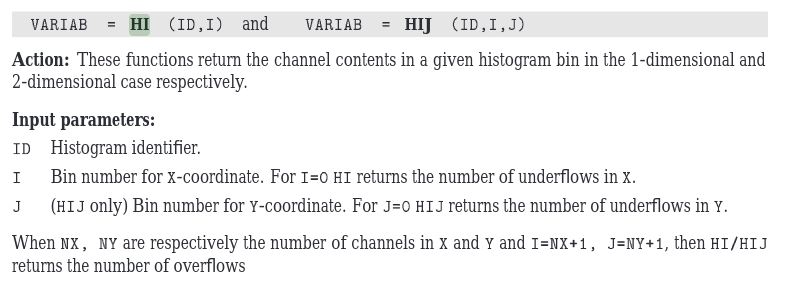

- For fun, let's see the slimmed down version:

In [279]:
# FOR TESTING ONLY
#def fluxfactors(sac, bsac, sbg, ctrue):
#    return [1,1,1], [1,1,1], [1,1,1]

In [130]:
def fluxlim(trisigflu, sac, sbg, k, normtrue, used, fluxfactor,
            background, nobs, bsac, width, filltrue, ctrue, spar, bar, bkpar, conflevel):
    # PYTHON
    fntot = [] # container for each experiment n_tot
    # Take flux from our MC
    bckfluxnom = background/fluxfactor
    # Perform Pseudo Experiments to calculate Integrals
    for i in range(100000): # change so this isn't hardcoded
        sigfactor, befactor, bkfactor = fluxfactors(sac, bsac, sbg, ctrue)
        # uncertainty in background flux    
        bckflux = bckfluxnom*bkfactor[bkpar-1] # check bkpar indexing
        # Diagnostics histograms
        if (filltrue == 1): 
            #call hfill(k+2000,bkfactor(bkpar),1.,1.)
            # FIXME!
            pass
        # include flux uncertainty
        musignal = trisigflu*fluxfactor*sigfactor[spar-1] # check indexing
        mubck  = bckflux*befactor[bar-1] # check indexing
        # Truncation for Gaussian uncertainty
        if (musignal < 0.) or (mubck < 0.):
            continue # want next iteration
        # generate signal and background
        nsig = np.random.poisson(lam=musignal, size=1)[0]
        nbck = np.random.poisson(lam=mubck, size=1)[0]
        if (normtrue==0): # without normalization
            n_tot = nsig+nbck # total number observed
            fntot.append(float(n_tot))
            # Diagnostics
            if (filltrue==1):
                # call hfill(k+100,fntot(nc),1.,1.)
                pass
        else: # with normalization
            # only keep event if nobs > nbck
            # should verify this enforces behavior given by cond
            if (nbck < nobs):  # < or <= ?
                n_tot = nsig+nbck
                fntot.append(float(n_tot))
                if (filltrue==1):
                    #call hfill(k+100,fntot(i),1.,1.)
                    pass
            else:
                continue

    fntot = np.array(fntot) # convert to array
    # normalizations, FC
    # sort in ascending order
    fntot = np.sort(fntot)
    # limiting index for Neyman UL
    jlim = round((1.-conflevel)*len(fntot)) - 1 # integer. if you use int() it rounds down!
    intjlim = jlim # unnecessary--using round
    nlim= fntot[intjlim]

    # make histogram "N Hist" (new for python version)
    #dist, _ = np.histogram(fntot, bins=np.arange(0,101,1)) # maybe 0, 102 so 100 is in different bin than 99
    dist, _ = np.histogram(fntot, bins=np.arange(0,102,1)) # maybe 0, 102 so 100 is in different bin than 99
    noent = np.sum(dist) # number of entries in histogram

    # FIXME
    #####call hfill(40,nlim,trisigflu,1.)

    # default value for checking later
    resflux = -1000 # can never be encountered for counting experiment
    # calculate Neyman upper limit for the passed in n0
    if (nlim == nobs+1):
        if (used == 0):
            resflux = trisigflu-width
            print(f'\nNeyman Upper Limit: {resflux}')
            #print *,' '
            #print 300,'Neyman Upper limit:',resflux
        used = 1

    return dist, noent, used, resflux, nlim
    # can derive noent from dist, but leaving for now

In [150]:
trisigflu=7.54
sac=0
sbg=0
k=0
normtrue=0 # condition
used=0
fluxfactor=1
background=3
nobs=6
width=0.01
filltrue=False
ctrue=False # corellations sig/bg eff unc.
spar = 1
bar = 1
bkpar = 1
conflevel = 0.9
dist, noent, used, resflux, nlim = fluxlim(trisigflu, sac, sbg, k, normtrue, used, fluxfactor,
                                           background, nobs, bsac, width, filltrue, ctrue, spar, bar, bkpar, conflevel)


Neyman Upper Limit: 7.53


In [142]:
dist

array([    4,    25,   148,   518,  1362,  2947,  5052,  7630,  9846,
       11620, 12433, 11863, 10203,  8383,  6430,  4473,  2923,  1892,
        1068,   618,   280,   133,    82,    43,    16,     4,     3,
           1,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [143]:
nlim

6.0

In [ ]:
# normalizations, FC
c non normalized.
      
      if (normtrue.eq.0) then
         call FLPSOR(fntot,nc)  
         jlim = (1.-conflevel)*nc
      endif
      
c     normalized
      
      if (normtrue.eq.1) then 
         call FLPSOR(fntot,j)
         jlim = (1.-conflevel)*j
      endif
      
c     Feldman Cousins ordering

      
      if (FCtrue.eq.1) then 
         
         do i=1,100
            dist(i) = HI(100,i)
         enddo 
      endif
      
      noent = hsum(100)
      
      intjlim = int(jlim)   
      nlim= fntot(intjlim)
      
      call hfill(40,nlim,trisigflu,1.)
      
      if (nlim.eq.nobs+1) then
         if (used.eq.0) then
            resflux = trisigflu-width
            print *,' '
        print 300,'Neyman Upper limit:',resflux
        
        
 300    FORMAT(' ',A,F6.2)
      endif
        used = 1
      endif
      
      
      return
      end

In [ ]:
ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
      subroutine fluxlim(trisigflu,sac,sbg,k,normtrue,used,fluxfactor, 
     >background,nobs,dist,FCtrue,bsac,noent,steps,width,filltrue,
     >ctrue,spar,bar,bkpar,conflevel)
c
c     This routine performs a Neyman Construction for P(flux;nobs) 
c     including systematic uncertainties
c
c     Author: Jan Conrad, February 2001       
c      
ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc


      

      real*4 efficiency,fluxfactor
      real*4 effa,conflevel
      real*4 sac,nlim,fntot(100000)
      real*4 sigfactor(3),bkfactor(3),befactor(3)
      real*4 trisigflu,bckflux,musignal,mubck,background
      real*4 a,b,sbg,bckfluxnom,resflux,bsac,width 
      integer n_tot,nbck,nsig,normtrue,steps,nobs
      integer k,used,FCtrue,dist(100),noent,nc,filltrue
      integer bar,spar,bkpar,ctrue      

c      Use this if you want to put in flux from theoretical calc
c      parameter (bckfluxnom = 123)

   
      character*50 filehb

      common /hbfile/ filehb

      parameter       (nbookw = 5000000)
      common /pawc/    hspace(nbookw)




       call hreset(100,' ')
      
      
c      Take flux from our MC
       bckfluxnom = background/fluxfactor

c Perform Pseudo Experiments to calculate Integrals
      
      j = 0
      nc = 0

      do i=1,100000



         call fluxfactors(sac,bsac,sbg,sigfactor,befactor,
     > bkfactor, ctrue)
      
         
c     uncertainty in background flux 
       
         bckflux = bckfluxnom*bkfactor(bkpar)


c Diagnostics histograms
          
         if (filltrue.eq.1) call hfill(k+2000,bkfactor(bkpar),1.,1.)

         
         
c     include flux uncertainty
         
         musignal = trisigflu*fluxfactor*sigfactor(spar)
         mubck  = bckflux*befactor(bar)
         

c     Truncation for Gaussian uncertainty 
         
         if (musignal.lt.0.or.mubck.lt.0.) goto 5000
      
         nc = nc + 1
         
         call rnpssn(musignal,nsig,ierror)
         call rnpssn(mubck,nbck,ierror)

         
c     without normalisation

         if (normtrue.eq.0) then
            n_tot = nsig+nbck
            fntot(nc) = float(n_tot)
            call hfill(100,fntot(nc),1.,1.)
c     Diagnostics

            if (filltrue.eq.1) call hfill(k+100,fntot(nc),1.,1.)
         endif  
         
c     with normalisation
         
         
         if (normtrue.eq.1) then
            if (nbck.le.nobs) then 
          j=j+1
          n_tot = nsig+nbck
         fntot(j) = float(n_tot)     
         call hfill(100,fntot(j),1.,1.)
c     Diagnostics
         if (filltrue.eq.1) call hfill(k+100,fntot(i),1.,1.)
      else
         goto 5000
      endif        
      endif 
      
      
 5000 enddo
      
c non normalized.
      
      if (normtrue.eq.0) then
         call FLPSOR(fntot,nc)  
         jlim = (1.-conflevel)*nc
      endif
      
c     normalized
      
      if (normtrue.eq.1) then 
         call FLPSOR(fntot,j)
         jlim = (1.-conflevel)*j
      endif
      
c     Feldman Cousins ordering

      
      if (FCtrue.eq.1) then 
         
         do i=1,100
            dist(i) = HI(100,i)
         enddo 
      endif
      
      noent = hsum(100)
      
      intjlim = int(jlim)   
      nlim= fntot(intjlim)
      
      call hfill(40,nlim,trisigflu,1.)
      
      if (nlim.eq.nobs+1) then
         if (used.eq.0) then
            resflux = trisigflu-width
            print *,' '
        print 300,'Neyman Upper limit:',resflux
        
        
 300    FORMAT(' ',A,F6.2)
      endif
        used = 1
      endif
      
      
      return
      end

### FC (lines 394-505)
**(DONE)** (Assuming I did not screw up indexing)
- 9 arguments

In [ ]:
      subroutine FC(matrix,fluxarray,nobs,nent,steps,filltrue,
     >     Philow,Phihigh,conflevel)                                                   
*********************************************************************
*                                                                  
*     performs Feldman Cousins Ordering. All likelihoods are 
*     calculated by the Monte Carlo
*     
*     010404 Jan Conrad
*
**********************************************************************

      

      real*4 matrix(1000,100),R(1000,100),fj
      real*4 fluxarray(1000),temp,hbflux,nlim1,nlim2,dum
      real*4 mtemp(1000),Rtemp(100),adder,Philow,Phihigh,P_best(100)
      integer index(100),n_limit(2,1000),nobs,nent(1000),steps,filltrue
      real*4 conflevel


* for each n find mu_best                                           

      do j= 1,100
         do i = 1,steps
            mtemp(i) = matrix(i,j)
         enddo
         call FLPSOR(mtemp,steps)
         P_best(j) = mtemp(steps)
         if (filltrue.eq.1) call hfill(31,P_best(j),fluxarray(i),1.)
      enddo



c for each flux calculate likelihood ratio for each n                

      do i = 1,steps

         do j = 1,100
           if (P_best(j).ne.0.and.matrix(i,j).ne.0) then
            R(i,j) = matrix(i,j)/P_best(j)
           else
            R(i,j) = 0.
           endif
         enddo
     

*     find i with highest R 

         do j = 1,100
            Rtemp(j) = R(i,j)
            fj = float(j-1)
c     Diagnostics
            if (filltrue.eq.1) call hfill(i+1100,fj,Rtemp(j),1.)
         enddo

      call sortzv(Rtemp,index,100,1,1,0,1)


c     add P(for that i)
c     until sum(P) = conflevel*100 %
      

      j = 0
      adder = 0.



      dum = conflevel*nent(i)

      do while(adder.lt.dum.and.j.lt.100)
         j = j+1
         adder = adder+matrix(i,index(j))   
      enddo
          
      call INTSOR(index,j)
      n_limit(1,i) = index(1)-1
      n_limit(2,i) = index(j)


* find flux which has nobs as upper limit (Philow) (shift due to indexing)    * find flux which has nobs as lower limit (Phihigh)                

      if (n_limit(1,i).eq.nobs) Phihigh = fluxarray(i)
      if (n_limit(2,i).eq.nobs) Philow = fluxarray(i)

* just to be able to have a look at the construction 
         
      nlim1 = float(n_limit(1,i))
      nlim2 = float(n_limit(2,i))

      hbflux = fluxarray(i)
      
      call hfill(50,nlim1,hbflux,1.)
      call hfill(50,nlim2,hbflux,1.)

      enddo  


      print *,' '
      print *,"exiting flux loop"

      print 300,' FC upper limit: ',Phihigh
      print 300,' FC lower limit: ',Philow



 300  FORMAT(' ',A,F6.2)

      print *,' '     
      print *,' '
    
      return
      end

In [ ]:
# PYTHON
#def FC(matrix,fluxarray,nobs,nent,steps,filltrue, Philow,Phihigh,conflevel):
def FC(matrix,fluxarray,nobs,nent,steps,filltrue, conflevel):

      

#      real*4 matrix(1000,100),R(1000,100),fj
#      real*4 fluxarray(1000),temp,hbflux,nlim1,nlim2,dum
#      real*4 mtemp(1000),Rtemp(100),adder,Philow,Phihigh,P_best(100)
#      integer index(100),n_limit(2,1000),nobs,nent(1000),steps,filltrue
#      real*4 conflevel

    P_best = np.zeros(100)
    R = np.zeros((steps, 100))
    n_limit = np.zeros((2, steps))
    
    Philow=0
    Phihigh=0

    # for each n find mu_best                                           
    for j in range(100):
        #for i in range(steps):
        #    mtemp[i] = matrix[i, j]
        mtemp = matrix[:,j] # cleaner
        mtemp = np.sort(mtemp) # sort in ascending order
        # CHECK IF TRUE
        P_best[j] = mtemp[-1] # best is mtemp with highest
        if (filltrue == 1):
            # FIXME! diagnostics
            #call hfill(31,P_best(j),fluxarray(i),1.)
            pass

    # for each flux calculate likelihood ratio for each n                
    for i in range(steps):
        for j in range(100):
            if (P_best[j] != 0) and (matrix[i,j] != 0):
                R[i,j] = matrix[i,j] / P_best[j]
            else:
                R[i,j] = 0

        # find i with highest R
        Rtemp = R[i,:] # cleaner

        '''
        Rtemp = np.zeros(100)
        for j in range(100):
            Rtemp[j] = R[i,j]
            fj = float(j)
            # Diagnostics
            if (filltrue == 1):
                # FIXME!
                # call hfill(i+1100,fj,Rtemp(j),1.)
                pass
        '''
        index = np.argsort(Rtemp)[::-1]

    # call sortzv(Rtemp,index,100,1,1,0,1)
    # sort Rtemp; index is output index array (should be integer array length 100)
    # 100 "words" to sort; 1--mode=real; 1--sort in descending order; 0--sort N values;
    # 1--extra?;
    # SEEMS TO HAVE ONE TOO MANY ARGUMENTS


        # add P(for that i)
        # until sum(P) = conflevel*100 %
        #j = 0
        adder = 0. # real
        dum = conflevel*nent[i] # real
        for j_ in range(100):
            j=j_ # CHECK
            if (adder >= dum):
                break
            adder += matrix[i, index[j_]]

        index_sorted = np.sort(index[:j]) # ascending sort
        n_limit[0,i] = index_sorted[0] # CHECK
        n_limit[1,i] = index_sorted[-1] + 1 # CHECK

        # find flux which has nobs as upper limit (Philow)
        # find flux which has nobs as lower limit (Phihigh) (shift due to indexing)             
        if (n_limit[0,i] == nobs):
            Phihigh = fluxarray[i]
        if (n_limit[1,i] == nobs):
            Philow = fluxarray[i] # I think this would give wrong result...not positive

        # just to be able to have a look at the construction 
        nlim1 = float(n_limit[0,i])
        nlim2 = float(n_limit[1,i])
        hbflux = fluxarray[i]
        # FIXME! Filling histogram ID=50
        #call hfill(50,nlim1,hbflux,1.)
        #call hfill(50,nlim2,hbflux,1.)
      
    print('\nexiting flux loop')
    print(f' FC upper limit: {Phihigh:0.5f}')
    print(f' FC lower limit: {Philow:0.5f}\n\n')

    return Philow, Phihigh, n_limit

### fluxfactors (lines 507-577)
**(DONE)**
- 7 arguments

In [ ]:
**************************************************************
      subroutine fluxfactors(sac,bsac,sbg,sigfactor,befactor,
     >bkfactor,ctrue)
*
********************************************************

      integer*4 ctrue
      real*4 sac,bsac,sbg,a,b,r,bkfactor(3)
      real*4 ranvec(3),befactor(3),sigfactor(3)

    

- Declarations (not needed for python)

In [ ]:
c     Gaussian distribution
      
      call rannor(a,b)
      call norran(r)
     
c     Uniform distribution 
      call ranlux(ranvec,3)
      
      
c signal efficiency factors:

      sigfactor(1) = 1+sac*r
      sigfactor(2) = (1-sac)+2*ranvec(1)*sac


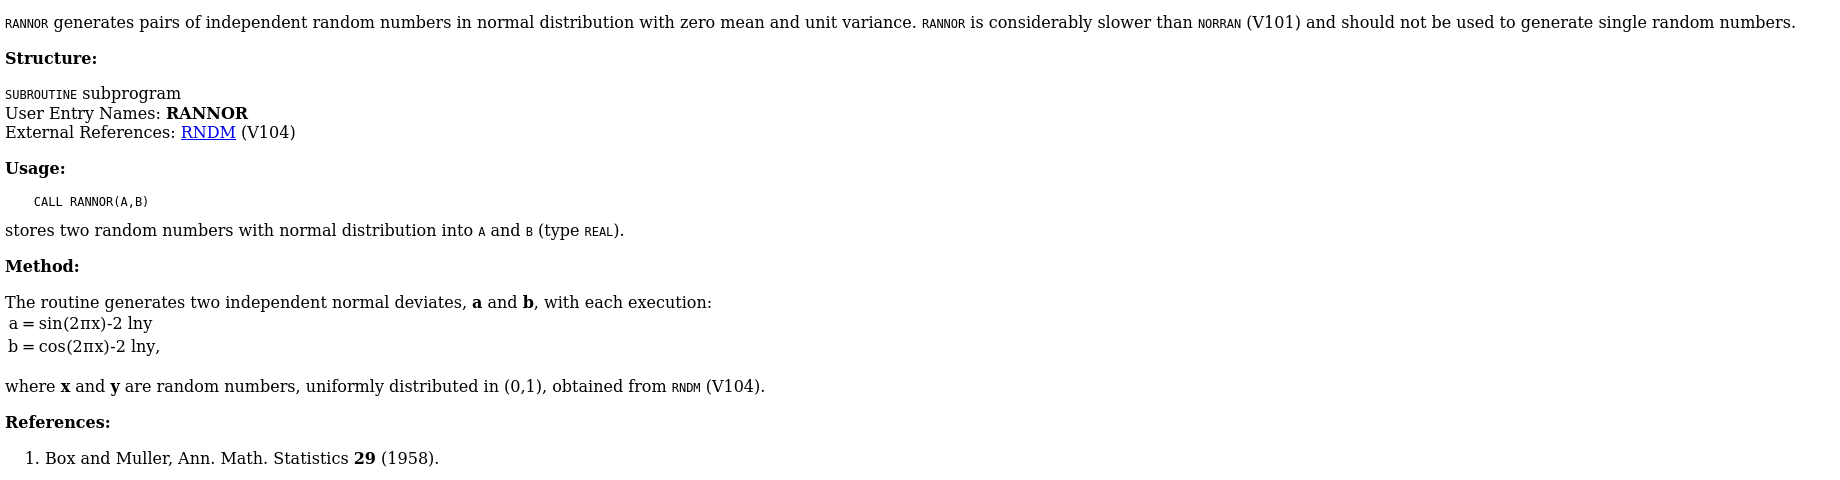

- NORRAN same but only 1 random value returned

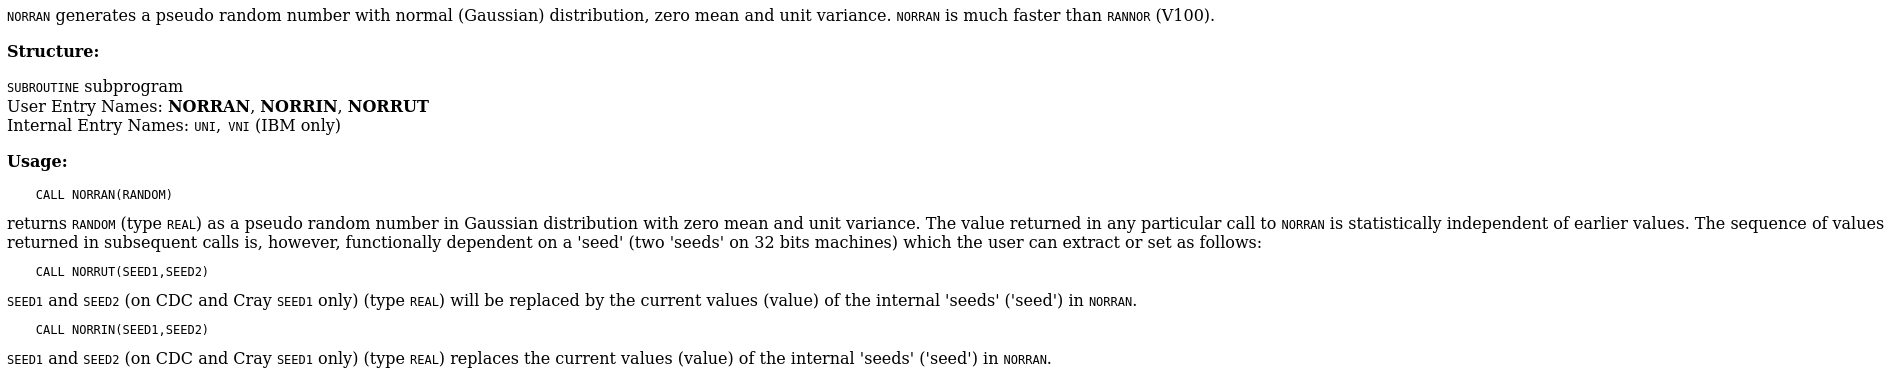

- **NORRAN and RANNOR both obsolete as of 1994, even though this was published in 2003...see CERN Computer Newsletter 215 (CNL 215)- https://cds.cern.ch/record/1292527/files/n-215.pdf**

- RANLUX (CERNLIB)
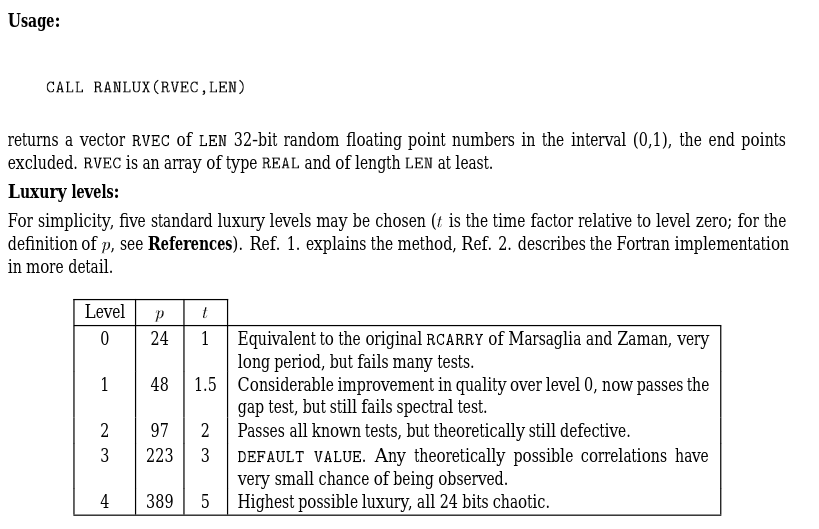

In [277]:
##### PYTHON
def fluxfactors(sac,bsac,sbg,ctrue):
    sigfactor = np.zeros(3) # signal eff. unc.
    befactor = np.zeros(3) # bg eff. unc.
    bkfactor = np.zeros(3) # expected bg unc.
    # Gaussian distribution; mu=0, std=1
    a,b,r = np.random.normal(loc=0, scale=1, size=3)

    # Uniform distribution 
    #call ranlux(ranvec,3)
    ranvec = np.random.uniform(low=0, high=1, size=3)

    # Conrad
    # signal efficiency factors:
    sigfactor[0] = 1+sac*r
    sigfactor[1] = (1-sac)+2*ranvec[0]*sac
    sigfactor[2] = np.exp(sac*r - sac**2/2)

    '''
    # Cole
    # CAN'T DO IF CORRELATING EFFICIENCIES
    # signal efficiency factors:
    sigfactor[0] = np.random.normal(loc=1,scale=sac) # Gaussian centered at 1 (mu=1, std=sac)
    sigfactor[1] = np.random.uniform(low=1-sac, high=1+sac) # uniform (1-sac, 1+sac)
    sigfactor[2] = np.random.lognormal(mean=-sac**2/2, sigma=sac) # lognormal with mean fixed to 1
    '''

    # background efficiency factors
    if (ctrue == 1): # correlated
        befactor[0] =  1+bsac*r
        befactor[1] =  (1-bsac)+2*ranvec[0]*bsac
        # mean of logN will be 1
        befactor[2] = np.exp(bsac*r - bsac**2/2)
    else: # no correlation
        befactor[0] =  1+bsac*a
        befactor[1] =  (1-bsac)+2*ranvec[1]*bsac
        # mean of logN will be 1
        befactor[2] = np.exp(bsac*a - bsac**2/2)

    # background prediction factors.
    bkfactor[0] = (1+sbg*b)
    bkfactor[1] = (1-sbg)+2*ranvec(3)*sbg     
    bkfactor[2] = exp(sbg*b - sbg*bsac/2)
    
    return sigfactor, befactor, bkfactor

In [157]:
ranvec

array([0.66257769, 0.39601491, 0.59540859])

In [ ]:
ccccccccccccccccccccccccccccccccccccccccccccccccc
c The log normal distribution is not symmetric
c We choose to fix the mean to 1, another choice
c would be to fix the peak (most probable value)
c to 1
c 
c No condition on the mean
c       expr = exp(sac*r)
c Fix mean value = 1
c      expr = exp(sac*r - sac*sac/2)
c Fix peak value = 1
c      expr = exp(sac*r + sac/2)
c
ccccccccccccccccccccccccccccccccccccccccccccccccc

      sigfactor(3) = exp(sac*r - sac*sac/2)

c background efficiency factors

c correlated
      
      befactor(1) =  1+bsac*r
      befactor(2) =  (1-bsac)+2*ranvec(1)*bsac

c   mean of logN will be 1
      befactor(3) = exp(bsac*r - bsac*bsac/2)

c no correlation

      if (ctrue.eq.0) then
         befactor(1) =  1+bsac*a
         befactor(2) = (1-bsac)+2*ranvec(2)*bsac
c mean of logN will be 1
         befactor(3) = exp(bsac*a - bsac*bsac/2)
      endif
      
c background prediction factors.
      
      bkfactor(1) = (1+sbg*b)
      bkfactor(2) = (1-sbg)+2*ranvec(3)*sbg     
      bkfactor(3) = exp(sbg*b - sbg*bsac/2)


      return
      end

In [ ]:
**************************************************************
      subroutine fluxfactors(sac,bsac,sbg,sigfactor,befactor,
     >bkfactor,ctrue)
*
********************************************************

      integer*4 ctrue
      real*4 sac,bsac,sbg,a,b,r,bkfactor(3)
      real*4 ranvec(3),befactor(3),sigfactor(3)

      
      
c     Gaussian distribution
      
      call rannor(a,b)
      call norran(r)
     
c     Uniform distribution 
      call ranlux(ranvec,3)
      
      
c signal efficiency factors:

      sigfactor(1) = 1+sac*r
      sigfactor(2) = (1-sac)+2*ranvec(1)*sac

ccccccccccccccccccccccccccccccccccccccccccccccccc
c The log normal distribution is not symmetric
c We choose to fix the mean to 1, another choice
c would be to fix the peak (most probable value)
c to 1
c 
c No condition on the mean
c       expr = exp(sac*r)
c Fix mean value = 1
c      expr = exp(sac*r - sac*sac/2)
c Fix peak value = 1
c      expr = exp(sac*r + sac/2)
c
ccccccccccccccccccccccccccccccccccccccccccccccccc

      sigfactor(3) = exp(sac*r - sac*sac/2)

c background efficiency factors

c correlated
      
      befactor(1) =  1+bsac*r
      befactor(2) =  (1-bsac)+2*ranvec(1)*bsac

c   mean of logN will be 1
      befactor(3) = exp(bsac*r - bsac*bsac/2)

c no correlation

      if (ctrue.eq.0) then
         befactor(1) =  1+bsac*a
         befactor(2) = (1-bsac)+2*ranvec(2)*bsac
c mean of logN will be 1
         befactor(3) = exp(bsac*a - bsac*bsac/2)
      endif
      
c background prediction factors.
      
      bkfactor(1) = (1+sbg*b)
      bkfactor(2) = (1-sbg)+2*ranvec(3)*sbg     
      bkfactor(3) = exp(sbg*b - sbg*bsac/2)


      return
      end


### readin (lines 580-704)
**(DONE)**
- 20 arguments

In [ ]:
*********************************************************************
*
      SUBROUTINE READIN(sac,sbg,fluxfactor,fmax,filehb,normtrue,
     >background,nobs,FCtrue,bsac,width,filltrue,ctrue,spar,bar,
     >bkpar,filetrue,filein,fileout,conflevel)

***********************************************************************
*     Purpose:
*     Read parameters for the confidence belt construction.
*     from pole.ini
*     Jan Conrad. 010606
***********************************************************************

      character dummy
      character*20 vers_nr
      character*50 filehb

      logical firstSpace

      
      

      integer normtrue,FCtrue,filltrue,ctrue
      real*4 sac,sbg,bsac,width,conflevel
      real*4 nmax,fmax,fluxfactor
      integer i,inunit,ispace,nobs,spar,bar,bkpar

      character*70 fileini,filein,fileout
      logical ReadOn
      character*2 Ident
      character*256 Line, Line1
      integer FirstNB, ExclM,filetrue

CC______________________________________________________________________

      itot=0
      ReadOn = .true.
      fileini = 'pole1.0.ini'
      inunit = 25
      open(inunit , file=fileini, status='old' )

      do while( ReadOn )

c --read one line of the init file
        call ReadLine( inunit, Line, IOError )
        if( IOError .ne. 0 )then
          if( IOError .eq. -1 )then ! EoF detecte
          else
            print*,' ***Error reading fileini, IOStat = ',IOError
          endif
          ReadOn = .false.
        endif

c --get the identifier
        Ident = Line( 1:2 )
        if( Ident(1:1).eq.'c' .or. Ident(1:1).eq.'C' .or.
     >    Ident(1:1).eq.'!'.or.Ident(1:1).eq.'#'.or.
     >    Ident(1:1).eq.'*' ) then
          Ident = '! '
        else
          FirstNB = 3
          do while( Line( FirstNB:FirstNB ) .eq. ' ' )
            FirstNB = FirstNB + 1
          enddo
          Line1 = Line( FirstNB:256 )
          ExclM = index( Line1, '!' )
          if( ExclM .eq. 0 ) ExclM = 257
          Line1 = Line1( 1:ExclM-1 )
        endif

     

c
c     --read ini file according to the identifier
        if( Ident .eq. '! ' ) then ! comment line
        elseif( Ident .eq. 'of' ) then ! hb name
           read( Line1, '(a)' )  filehb
        elseif( Ident .eq. 'ft' ) then ! fill diagnostic histogramms
           read( Line1, * )  filltrue
        elseif( Ident .eq. 'ff' ) then ! fluxfactor
           read( Line1, * )  fluxfactor
        elseif( Ident .eq. 'll' ) then ! confidence level
           read( Line1, * ) conflevel
        elseif( Ident .eq. 'fi' ) then ! Read input from file
           read( Line1, * )  filetrue
        elseif ( Ident .eq. 'fn' ) then ! file with input
           read( Line1, '(a)' ) filein
        elseif ( Ident .eq. 'fo' ) then ! file output
           read( Line1, '(a)' ) fileout
        elseif( Ident .eq. 'rf' ) then ! Range of Flux
           read( Line1, * ) fmax
        elseif( Ident .eq. 'sw' ) then ! stepwidth
           read( Line1, * ) width
        elseif (Ident. eq. 'no' ) then ! use normalisation
           read( Line1, *)  normtrue
        elseif (Ident. eq. 'fc' ) then ! perform FC
           read( Line1, *)  FCtrue
        elseif (Ident. eq. 'bg' ) then ! exp. background
           read( Line1, * ) background
        elseif (Ident. eq. 'nm' ) then ! n observed
           read( Line1, * ) nobs
        elseif (Ident. eq. 'cc' ) then ! correlation true ?
           read( Line1, * ) ctrue
        elseif( Ident .eq. 'bu' ) then ! Backgr. Uncertainty 
           read( Line1, * ) sbg
        elseif( Ident .eq. 'pb' ) then ! its parametrization 
           read( Line1, * ) bkpar
        elseif( Ident .eq. 'eu' ) then ! eff A uncertainty 
           read( Line1, * ) sac
        elseif( Ident .eq. 'pu' ) then ! its parametrization
           read( Line1, * ) spar
        elseif( Ident .eq. 'eb' ) then ! eff A uncertainty 
           read( Line1, * ) bsac
        elseif( Ident .eq. 'pe' ) then ! its parametrization
           read( Line1, * ) bar          
       else
          print*,' *** Warning in ReadInit ***'
          print*,'     Unknown identifier, Ident = ', Ident
        endif
      enddo
c
      close(inunit)

      return
      end

### readline (lines 706-719)
**(DONE/NOT NEEDED)**
- 3 arguments

In [ ]:
***********************************************************************
      SUBROUTINE READLINE( LUn, Line, Error )
***********************************************************************
c
      integer LUn
      character*256 Line
      integer Error
c
      read( LUn, '(a)', iostat=Error ) Line
c


      return
      end

### readgrid (lines 721-749)
**(DONE)**
- 4 arguments

In [ ]:
***********************************************************************
      subroutine read_grid(name,x,y,counter)
***********************************************************************
      character*70 name
 
      integer imax, counter
      real*4 x(10000), y(10000),z(10000),fi(10000)
      real*4 d1(10000),d2(10000),d3(10000)

      imax = 10000
      
      open( unit = 7, file = name, status = 'old')

ccccccccccccccccccccccccccccccccccccccccccccccccc
c y  = number of observed events
c x  = background
c Jan Conrad, Juli, 2003
cccccccccccccccccccccccccccccccccccccccccccccccc

      counter = 0
      do i=1,imax
       read(7,*,end=999,err=999) y(i),x(i)

           counter = counter+1
      enddo

 999  close(7)
      return
      end

# Imports (Python)

In [50]:
import numpy as np

# Completed Functions (Python)

In [52]:
def readin(filename='data/pole1.0.ini', verbose=True):
    # read in initialization file. remove newline character and ignore comments (line starts with "!")
    with open(filename, 'r') as f:
        lines = [i.rstrip('\n').rstrip(' ') for i in f.readlines() if not i[0] in ['!', '#', '*', 'C']]#, 'c', ]]
    # loop through lines to set proper variables
    for line in lines:
        #print(line)
        ident, val = line.split(' ')
        if ident=='of':
            filehb = val
        elif ident=='ft':
            filltrue = int(val)
        elif ident=='ff':
            fluxfactor = float(val)
        elif ident=='ll':
            conflevel = float(val)
        elif ident=='fi':
            filetrue = int(val)
        elif ident=='fn':
            filein = val
        elif ident=='fo':
            fileout = val
        elif ident=='rf':
            fmax = float(val)
        elif ident=='sw':
            width = float(val)
        elif ident=='no':
            normtrue = int(val)
        elif ident=='fc':
            FCtrue = int(val)
        elif ident=='bg':
            background = float(val)
        elif ident=='nm':
            nobs = int(val)
        elif ident=='cc':
            ctrue = int(val)
        elif ident=='bu':
            sbg = float(val)
        elif ident=='pb':
            bkpar = int(val)
        elif ident=='eu':
            sac = float(val)
        elif ident=='pu':
            spar = int(val)
        elif ident=='eb':
            bsac = float(val)
        elif ident=='pe':
            bar = int(val)
    # calculate number of steps
    step_help = fmax/width
    steps = int(step_help)
    if verbose:
        # Tell User which parameters: 
        print('Performing Conf Belt Const :')
        print(f'Output hbfile:     {filehb}')  
        print(f'fill diagnostic histos {filltrue}')
        print(f'Confidence Level {conflevel:0.5f}')
        print(f'Condition (1=yes) {normtrue}')
        print(f'stepwidth : {width:0.3f}')
        print(f'Feldman Cousins    {FCtrue}')
        print(f'fluxfactor:        {fluxfactor:0.3f}')
        print(f'Read from file: {filein}')
        print(f'Write to file: {fileout}')
        print(f'Exp. BG events     {background:0.3f}')
        print(f'Measured events    {nobs}')
        print(' ')
        print('Used Paramterisation :')
        print('Gaussian = 1')
        print('flat = 2')
        print('log-normal = 3')
        print(' ')
        print(f'rel Aeff unc (sig): {sac:0.3f}')
        print(f'Parametrization: {spar}')
        print(f'rel Aeff unc (bck): {bsac:0.3f}')
        print(f'Parametrization: {bar}')
        print(f'rel bg unc:        {sbg:0.3f}')
        print(f'Parametrization: {bkpar}')
        print(f'max flux:          {fmax:0.3f}')
        print(f'Number of steps: {steps}')
        print('CAUTION: not bigger than 1000!')
    #return lines
    return filehb, filltrue, fluxfactor, conflevel, filetrue, filein, fileout, fmax, width,\
           normtrue, FCtrue, background, nobs, ctrue, sbg, bkpar, sac, spar, bsac, bar, steps

In [53]:
def read_grid(filename='data/test.in'):
    '''
    x = background
    y = number of observed events
    '''
    x = []; y = []
    # read in input file. remove newline character
    with open(filename, 'r') as f:
        lines = [i.rstrip('\n').rstrip(' ') for i in f.readlines()]
    # loop through lines to grab x, y values set proper variables
    for line in lines:
        y_, x_ = line.split(' ')
        x.append(float(x_))
        y.append(float(y_))
    x = np.array(x)
    y = np.array(y)
    ncalc = len(x)
    return x, y, ncalc

In [298]:
def fluxfactors(sac,bsac,sbg,ctrue):
    sigfactor = np.zeros(3) # signal eff. unc.
    befactor = np.zeros(3) # bg eff. unc.
    bkfactor = np.zeros(3) # expected bg unc.
    # Gaussian distribution; mu=0, std=1
    a,b,r = np.random.normal(loc=0, scale=1, size=3)

    # Uniform distribution 
    #call ranlux(ranvec,3)
    ranvec = np.random.uniform(low=0, high=1, size=3)

    # Conrad
    # signal efficiency factors:
    sigfactor[0] = 1+sac*r
    sigfactor[1] = (1-sac)+2*ranvec[0]*sac
    sigfactor[2] = np.exp(sac*r - sac**2/2)

    '''
    # Cole
    # CAN'T DO IF CORRELATING EFFICIENCIES
    # signal efficiency factors:
    sigfactor[0] = np.random.normal(loc=1,scale=sac) # Gaussian centered at 1 (mu=1, std=sac)
    sigfactor[1] = np.random.uniform(low=1-sac, high=1+sac) # uniform (1-sac, 1+sac)
    sigfactor[2] = np.random.lognormal(mean=-sac**2/2, sigma=sac) # lognormal with mean fixed to 1
    '''

    # background efficiency factors
    if (ctrue == 1): # correlated
        befactor[0] =  1+bsac*r
        befactor[1] =  (1-bsac)+2*ranvec[0]*bsac
        # mean of logN will be 1
        befactor[2] = np.exp(bsac*r - bsac**2/2)
    else: # no correlation
        befactor[0] =  1+bsac*a
        befactor[1] =  (1-bsac)+2*ranvec[1]*bsac
        # mean of logN will be 1
        befactor[2] = np.exp(bsac*a - bsac**2/2)

    # background prediction factors.
    bkfactor[0] = (1+sbg*b)
    bkfactor[1] = (1-sbg)+2*ranvec[2]*sbg     
    bkfactor[2] = np.exp(sbg*b - sbg*bsac/2)
    
    return sigfactor, befactor, bkfactor

In [303]:
def fluxlim(trisigflu, sac, sbg, k, normtrue, used, fluxfactor,
            background, nobs, bsac, width, filltrue, ctrue, spar, bar, bkpar, conflevel):
    # PYTHON
    fntot = [] # container for each experiment n_tot
    # Take flux from our MC
    bckfluxnom = background/fluxfactor
    # Perform Pseudo Experiments to calculate Integrals
    for i in range(100000): # change so this isn't hardcoded
        sigfactor, befactor, bkfactor = fluxfactors(sac, bsac, sbg, ctrue)
        # uncertainty in background flux    
        bckflux = bckfluxnom*bkfactor[bkpar-1] # check bkpar indexing
        # Diagnostics histograms
        if (filltrue == 1): 
            #call hfill(k+2000,bkfactor(bkpar),1.,1.)
            # FIXME!
            pass
        # include flux uncertainty
        musignal = trisigflu*fluxfactor*sigfactor[spar-1] # check indexing
        mubck  = bckflux*befactor[bar-1] # check indexing
        # Truncation for Gaussian uncertainty
        if (musignal < 0.) or (mubck < 0.):
            continue # want next iteration
        # generate signal and background
        nsig = np.random.poisson(lam=musignal, size=1)[0]
        nbck = np.random.poisson(lam=mubck, size=1)[0]
        if (normtrue==0): # without normalization
            n_tot = nsig+nbck # total number observed
            fntot.append(float(n_tot))
            # Diagnostics
            if (filltrue==1):
                # call hfill(k+100,fntot(nc),1.,1.)
                pass
        else: # with normalization
            # only keep event if nobs > nbck
            # should verify this enforces behavior given by cond
            if (nbck < nobs):  # < or <= ?
                n_tot = nsig+nbck
                fntot.append(float(n_tot))
                if (filltrue==1):
                    #call hfill(k+100,fntot(i),1.,1.)
                    pass
            else:
                continue

    fntot = np.array(fntot) # convert to array
    # normalizations, FC
    # sort in ascending order
    fntot = np.sort(fntot)
    # limiting index for Neyman UL
    jlim = round((1.-conflevel)*len(fntot)) - 1 # integer. if you use int() it rounds down!
    intjlim = jlim # unnecessary--using round
    nlim= fntot[intjlim]

    # make histogram "N Hist" (new for python version)
    dist, _ = np.histogram(fntot, bins=np.arange(0,101,1)) # maybe 0, 102 so 100 is in different bin than 99
    #dist, _ = np.histogram(fntot, bins=np.arange(0,102,1)) # maybe 0, 102 so 100 is in different bin than 99
    noent = np.sum(dist) # number of entries in histogram

    # FIXME
    # needed for FC?
    #####call hfill(40,nlim,trisigflu,1.)

    # default value for checking later
    resflux = -1000 # can never be encountered for counting experiment
    # calculate Neyman upper limit for the passed in n0
    if (nlim == nobs+1):
        if (used == 0):
            resflux = trisigflu-width
            print(f'\nNeyman Upper Limit: {resflux}')
            #print *,' '
            #print 300,'Neyman Upper limit:',resflux
        used = 1

    return dist, noent, used, resflux, nlim
    # can derive noent from dist, but leaving for now

In [304]:
# PYTHON
#def FC(matrix,fluxarray,nobs,nent,steps,filltrue, Philow,Phihigh,conflevel):
def FC(matrix,fluxarray,nobs,nent,steps,filltrue, conflevel):

      

#      real*4 matrix(1000,100),R(1000,100),fj
#      real*4 fluxarray(1000),temp,hbflux,nlim1,nlim2,dum
#      real*4 mtemp(1000),Rtemp(100),adder,Philow,Phihigh,P_best(100)
#      integer index(100),n_limit(2,1000),nobs,nent(1000),steps,filltrue
#      real*4 conflevel

    P_best = np.zeros(100)
    R = np.zeros((steps, 100))
    n_limit = np.zeros((2, steps))
    
    Philow=0
    Phihigh=0

    # for each n find mu_best                                           
    for j in range(100):
        #for i in range(steps):
        #    mtemp[i] = matrix[i, j]
        mtemp = matrix[:,j] # cleaner
        mtemp = np.sort(mtemp) # sort in ascending order
        # CHECK IF TRUE
        P_best[j] = mtemp[-1] # best is mtemp with highest
        if (filltrue == 1):
            # FIXME! diagnostics
            #call hfill(31,P_best(j),fluxarray(i),1.)
            pass

    # for each flux calculate likelihood ratio for each n                
    for i in range(steps):
        for j in range(100):
            if (P_best[j] != 0) and (matrix[i,j] != 0):
                R[i,j] = matrix[i,j] / P_best[j]
            else:
                R[i,j] = 0

        # find i with highest R
        Rtemp = R[i,:] # cleaner

        '''
        Rtemp = np.zeros(100)
        for j in range(100):
            Rtemp[j] = R[i,j]
            fj = float(j)
            # Diagnostics
            if (filltrue == 1):
                # FIXME!
                # call hfill(i+1100,fj,Rtemp(j),1.)
                pass
        '''
        index = np.argsort(Rtemp)[::-1]

    # call sortzv(Rtemp,index,100,1,1,0,1)
    # sort Rtemp; index is output index array (should be integer array length 100)
    # 100 "words" to sort; 1--mode=real; 1--sort in descending order; 0--sort N values;
    # 1--extra?;
    # SEEMS TO HAVE ONE TOO MANY ARGUMENTS


        # add P(for that i)
        # until sum(P) = conflevel*100 %
        #j = 0
        adder = 0. # real
        dum = conflevel*nent[i] # real
        for j_ in range(100):
            j=j_ # CHECK
            if (adder >= dum):
                break
            adder += matrix[i, index[j_]]

        index_sorted = np.sort(index[:j]) # ascending sort
        n_limit[0,i] = index_sorted[0] # CHECK
        n_limit[1,i] = index_sorted[-1] + 1 # CHECK

        # find flux which has nobs as upper limit (Philow)
        # find flux which has nobs as lower limit (Phihigh) (shift due to indexing)             
        if (n_limit[0,i] == nobs):
            Phihigh = fluxarray[i]
        if (n_limit[1,i] == nobs):
            Philow = fluxarray[i] # I think this would give wrong result...not positive

        # just to be able to have a look at the construction 
        nlim1 = float(n_limit[0,i])
        nlim2 = float(n_limit[1,i])
        hbflux = fluxarray[i]
        # FIXME! Filling histogram ID=50
        #call hfill(50,nlim1,hbflux,1.)
        #call hfill(50,nlim2,hbflux,1.)
      
    print('\nexiting flux loop')
    print(f' FC upper limit: {Phihigh:0.5f}')
    print(f' FC lower limit: {Philow:0.5f}\n\n')

    return Philow, Phihigh, n_limit

# Main Function (Python)

In [305]:
def main():
    # read in steering file and print program configuration
    filehb, filltrue, fluxfactor, conflevel, filetrue, filein, fileout, fmax, width,\
        normtrue, FCtrue, background, nobs, ctrue, sbg, bkpar, sac, spar, bsac, bar, steps\
        = readin()
    if filetrue:
        x, y, ncalc = read_grid(filename='data/'+filein)
        print('-\n-\nMode: Read input from file\n-')
    else:
        x = np.array([background]) # check
        y = np.array([nobs]) # check
        ncalc = 1
        print('-\n-\nMode: single construction\n-')
    print(f'expected background (x): {x}')
    print(f'number of observed (y): {y}')
    
    #### GOOD TO THIS POINT
    # open output file
    fout = open(fileout, "w")
    # Loop over input nobs/BG pairs
    for p in range(ncalc):
        fluxarray = np.zeros(steps)
        matrix = np.zeros((steps, 100))
        nent = np.zeros(steps)
        Philow=0.
        Phihigh=0.
        # FIXME! Reset histogram IDs: 50, 40, 100
        nobs_ = y[p]
        background_ = x[p]
        #print(f'-\nPerforming Construction for n0/bg: {nobs_}/{background_}\n-\n-\nRanLux Messages\n-\n')
        # message without "RanLux" Statement
        print(f'-\nPerforming Construction for n0/bg: {nobs_}/{background_}\n-\n-\n')
        trisigflux= 0.0
        # Scan through flux space and perform Construction
        used = 0
        # FIXME! Reset histogram ID: 20
        # Loop through trisigflux to try
        for i in range(steps):
            # progress tracker
            # FIXME! Update to tqdm progress bar
            if (i % int(steps/20)) == 0:
                print('.')
            
            # INCREMENTS TWICE EACH LOOP--BAD!!!
            #trisigflux =trisigflux+width # this starts us above 0?
            #fluxarray[i] = trisigflux
            
            # Diagnostics histogramms
            if (filltrue == 1):
                # FIXME! diagnostics
                #nh = 100 + i
                #call hbook1(nh,'N Dist',100,0.,100.,0.)
                pass
            
            # call fluxlim
            dist, noent, used, resflux, nlim = fluxlim(trisigflux, sac, sbg, i, normtrue, used,
                                                       fluxfactor, background_, nobs_, bsac, width,
                                                       filltrue, ctrue, spar, bar, bkpar, conflevel)
            # fill matrix for Feldman Cousins
            #for l in range(100):
            #    matrix[i,l] = dist[l]
            matrix[i, :] = dist # cleaner
            nent[i] = noent
            # Diagnostics histogramms
            if (filltrue == 1):
                # FIXME! diagnostics
                # nh = 1100 + i
                #call hbook2(nh,'Rank Dist.',100,0.,50.,10,0.,1.,1.)
                pass
            fluxarray[i] = trisigflux
            trisigflux += width
            
        # Perform Likelihood Ratio construction 
        if (FCtrue == 1):
            Philow, Phihigh, n_limit = FC(matrix,fluxarray,nobs_,nent,steps,filltrue, conflevel)

        # Write output to file !
        fout.write(f'{nobs_}, {background_}, {Philow}, {Phihigh}\n')
    # outside nobs/background loop
    fout.close()
    
    print('Calculation complete!')

In [308]:
main()

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.100
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     3.000
Measured events    7
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 1
max flux:          15.000
Number of steps: 150
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [3.]
number of observed (y): [7]
-
Performing Construction for n0/bg: 7/3.0
-
-

.
.
.
.
.
.
.
.
.
.
.
.
.

Neyman Upper Limit: 8.699999999999985
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 9.60000
 FC lower limit: 0.80000


Calculation complete!


- Currently runs quite a bit slower than FORTRAN
- Vectorize and should run quicker.
- Could also try using Gaussian approx for mu>20 (Poisson)

# SCRATCH

## Log Normal vs. Gaussian

In [79]:
N = 100000
mu = 1
std = 0.4
var = std**2

In [80]:
# generate gaussian and look at sample mean / std
xs = np.random.normal(loc=mu, scale=std, size=N)

In [81]:
xs.mean(), xs.std()

(1.001047438157665, 0.39941000718227043)

In [82]:
std_ln = std
mu_ln = np.log(mu) - std**2 / 2

In [84]:
std_ln, mu_ln

(0.4, -0.08000000000000002)

In [87]:
# generate log-normal
ys = np.random.lognormal(mean=mu_ln, sigma=std_ln, size=N)

In [88]:
ys.mean(), ys.std()

(0.9982725656238518, 0.41613017191659896)

- These look pretty close! Let's try the wiki method, which should get both spot on

In [93]:
mu_ln = np.log(mu**2 / (mu**2 + std**2)**(1/2))
std_ln = (np.log(1+std**2/mu**2))**(1/2)

In [94]:
mu_ln, std_ln

(-0.07421000255913678, 0.38525317015992666)

In [95]:
# generate log-normal
ys = np.random.lognormal(mean=mu_ln, sigma=std_ln, size=N)

In [96]:
ys.mean(), ys.std()

(0.9986280186915583, 0.3984484719297211)

- Looks about the same as Conrad result.

**Prescription**
- $\mu, \sigma$ for a nuisance parameter given (expected background, signal efficiency, background efficiency)
- If log-normal parameterization selected (3), then:
    - $\mu_{LN} = \ln{\mu} - \sigma^2 / 2$
    - $\sigma_{LN} = \sigma$
    - These are the parameters to use with the log-normal generator